In [1]:
import numpy as np
import pandas as pd
import torch

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score
#from catboost import CatBoostClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/zadanie/silero-stress-predictor/train.csv', index_col=[0])

In [4]:
df_test = pd.read_csv('/content/drive/MyDrive/zadanie/silero-stress-predictor/test.csv', index_col=[0])

In [ ]:
df_train

,word,stress,num_syllables,lemma
id,,,,
0,румяной,2,3,румяный
1,цифрами,1,3,цифра
2,слугами,1,3,слуга
3,выбирает,3,4,выбирать
4,управдом,3,3,управдом
...,...,...,...,...
63433,экзамена,2,4,экзамен
63434,культурой,2,3,культура
63435,объемной,2,3,объемный


In [ ]:
df_test

,word,num_syllables,lemma
id,,,
0,эпилепсия,5,эпилепсия
1,относящейся,5,относиться
2,размышлениями,6,размышление
3,модемы,3,модем
4,солнц,1,солнце
...,...,...,...
29955,донбасса,3,донбасс
29956,обложка,3,обложка
29957,правителя,4,правитель


In [ ]:
X = df_train.copy()
y = X.pop('stress')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2)

In [ ]:
baseline_model = CatBoostClassifier(learning_rate=0.25, iterations=50)

In [ ]:
cat_feat = list(X.columns)

In [ ]:
cat_feat

['word', 'num_syllables', 'lemma']

In [ ]:
baseline_model.fit(X_train, y_train, cat_features=cat_feat)

0:	learn: 1.4587517	total: 97.7ms	remaining: 4.79s
1:	learn: 1.0987225	total: 143ms	remaining: 3.44s
2:	learn: 0.9447673	total: 185ms	remaining: 2.9s
3:	learn: 0.8496705	total: 229ms	remaining: 2.64s
4:	learn: 0.7861360	total: 273ms	remaining: 2.46s
5:	learn: 0.7418657	total: 316ms	remaining: 2.32s
6:	learn: 0.7083622	total: 359ms	remaining: 2.21s
7:	learn: 0.6836122	total: 408ms	remaining: 2.14s
8:	learn: 0.6654717	total: 450ms	remaining: 2.05s
9:	learn: 0.6515110	total: 495ms	remaining: 1.98s
10:	learn: 0.6416433	total: 540ms	remaining: 1.91s
11:	learn: 0.6325842	total: 585ms	remaining: 1.85s
12:	learn: 0.6262230	total: 622ms	remaining: 1.77s
13:	learn: 0.6208394	total: 660ms	remaining: 1.7s
14:	learn: 0.6170771	total: 695ms	remaining: 1.62s
15:	learn: 0.6145694	total: 727ms	remaining: 1.54s
16:	learn: 0.6114261	total: 768ms	remaining: 1.49s
17:	learn: 0.6089933	total: 811ms	remaining: 1.44s
18:	learn: 0.6070307	total: 854ms	remaining: 1.39s
19:	learn: 0.6048774	total: 899ms	remainin

In [ ]:
y_train_pred = baseline_model.predict(X_train)

In [ ]:
accuracy_score(y_train, y_train_pred)

0.943231527093596

In [ ]:
y_valid_pred = baseline_model.predict(X_valid)

In [ ]:
accuracy_score(y_valid, y_valid_pred)

0.8311790668348046

## Модель

In [6]:
list_train = list(df_train['word'])
list_test = list(df_test['word'])
list_lemma_train = list(df_train['lemma'])
list_lemma_test = list(df_test['lemma'])

In [7]:
list_num_slogov_train = list(df_train['num_syllables'])
list_num_slogov_test = list(df_test['num_syllables'])

In [8]:
glasn_list = ['а', 'я', 'у', 'ю', 'о', 'е', 'ё', 'э', 'и', 'ы']
soglasn_list = ['б','в','г','д','ж','з','к','п','с','т','ф','х','ц','ч','ш','щ']
sonor_list = ['л','м','н','р','й']
dop_list = ['ь','ъ']

In [ ]:
#letters_dict = {'а':240,'я':241,'у':242,'ю':243,'о':244,'е':248,'ё':249,'э':247,'и':246,'ы':245,
              #  'б':150,'в':151,'г':152,'д':153,'ж':154,'з':155,
              #  'к':100,'п':101,'с':102,'т':103,'ф':104,'х':105,'ц':106,'ч':107,'ш':108,'щ':109,
              #  'л':180,'м':181,'н':182,'р':183,'й':184,
              #  'ь':50,'ъ':51, '0':0}

In [9]:
letters_dict = {'а':225,'я':200,'у':230,'ю':205,'о':235,'е':210,'ё':215,'э':240,'и':220,'ы':245,
                'б':170,'в':175,'г':180,'д':165,'ж':160,'з':185,
                'к':70,'п':75,'с':80,'т':85,'ф':90,'х':95,'ц':100,'ч':105,'ш':110,'щ':115,
                'л':130,'м':135,'н':140,'р':145,'й':150,
                'ь':40,'ъ':45, '0':0}

In [10]:
def slog_split(word_list, list_num_slogov):
    new_word_list = []
    #word = 'разглагольствовать'
    #word = 'арбалет'
    #word = 'арбуз'
    for word, slogov in zip(word_list,list_num_slogov):
        new_word = ''
        #slogov = 3
        counter_slogov = 0
        word = word+'  '
        for i in range(len(word)):
            if i==0:
                if word[i] in glasn_list:
                    counter_slogov += 1
                    if counter_slogov == slogov:
                        new_word += word[i]
                    else:
                        new_word += word[i]
                        if word[i+1] in glasn_list:
                            new_word += '-'
                        if word[i+1] in soglasn_list:
                            new_word += '-'
                        if word[i+1] in sonor_list:
                            if word[i+2] in glasn_list:
                                new_word += '-'
                else:
                    new_word += word[i]
            #if i==len(word)-1:

            else:
                if word[i] in glasn_list:
                    counter_slogov += 1
                    if counter_slogov == slogov:
                        new_word += word[i]
                    else:
                        new_word += word[i]
                        if word[i+1] in glasn_list:
                            new_word += '-'
                        if word[i+1] in soglasn_list:
                            new_word += '-'
                        if word[i+1] in sonor_list:
                            if word[i+2] in glasn_list:
                                new_word += '-'
                            if word[i+2] == word[i+1]: #парные сонорные НН
                                new_word += '-'
                if word[i] in soglasn_list:
                    new_word += word[i]
                if word[i] in dop_list:
                    if counter_slogov == slogov:
                        new_word += word[i]
                    else:
                        new_word += word[i]+'-'
                if word[i] in sonor_list:
                    if counter_slogov == slogov:
                        new_word += word[i]
                    else:
                        if word[i-1] in glasn_list and word[i+1] in soglasn_list:
                            new_word += word[i]+'-'
                        #дефис между двумя сонорными М-Н, М-Л:
                        elif word[i-1] in glasn_list and word[i+1] in sonor_list and word[i+1]!=word[i]: 
                            new_word += word[i]+'-'
                        else:
                            new_word += word[i]
        new_word_list.append(new_word)
                    
    return new_word_list

In [12]:
train_words_splitted = slog_split(list_train, list_num_slogov_train)
train_words_splitted

['ру-мя-ной',
 'ци-фра-ми',
 'слу-га-ми',
 'вы-би-ра-ет',
 'у-пра-вдом',
 'ку-пю-ру',
 'чёр-та',
 'куль-тур-ной',
 'мэ-ри-и',
 'мар-кер-ны-е',
 'кра-со-те',
 'кро-ва-вым',
 'э-ли-ту',
 'па-ра-гра-фе',
 'ю-ри-ди-че-ско-му',
 'силь-ви-и',
 'вы-де-ле-ни-ю',
 'пе-ре-го-во-рах',
 'ро-ди-тель-ский',
 'при-ка-жи-те',
 'ка-на-дских',
 'о-бжа-рить',
 'здо-ро-вом',
 'ре-пе-ти-то-ров',
 'со-кро-ве-нным',
 'а-бха-зи-ю',
 'мо-ря-ков',
 'и-стре-би-те-ля-ми',
 'на-ра-ста-ю-щим',
 'вы-со-там',
 'пасс',
 'ссо-ри-лись',
 'жир-но-е',
 'де-ти-на',
 'хро-ник',
 'ка-са-ю-ще-е-ся',
 'пре-дпо-сыл-ки',
 'ме-жре-ги-о-наль-ных',
 'во-зду-шной',
 'ли-шив',
 'о-кку-па-ци-и',
 'тро-ту-ар-на-я',
 'о-це-ни-ла',
 'у-чё-ных',
 'ди-а-па-зо-ном',
 'о-бра-тно-е',
 'ра-зби-то-го',
 'сбро-са',
 'шлей-фы',
 'ли-кбез',
 'эр-ми-та-жа',
 'кар-га-поль-е',
 'про-и-сше-дше-го',
 'жё-стко',
 'при-ку-ри-ва-тель',
 'фер-ме',
 'о-тво-дит',
 'ме-же-ва-ни-е',
 'ка-да-стро-вой',
 'во-ло-са-ту-ю',
 'не-у-добств',
 'шам-пинь-о-нов',
 'крыл

In [11]:
def fix(list_words_splitted):
    fixed_words_list = []
    for i in list_words_splitted:
        fixed_word = ''
        for j in i.split('-'):
            gl_count = 0
            for k in j:
                if k in glasn_list:
                    gl_count += 1
            if gl_count == 0:
                fixed_word = fixed_word[:-1] #стираем лишний дефис
                fixed_word += j+'-'
            else:
                fixed_word +=j+'-'
        fixed_word = fixed_word[:-1]
        fixed_words_list.append(fixed_word)
    return fixed_words_list



In [13]:
test_words_splitted = slog_split(list_test, list_num_slogov_test)

In [14]:
def glasn_count(lemma_list):
    slogov_vsego = []
    for i in lemma_list:
        count = 0
        for j in i:
            if j in glasn_list:
                count += 1
        slogov_vsego.append(count)
    return slogov_vsego

In [15]:
list_num_lemma_train = glasn_count(list_lemma_train)
list_num_lemma_test = glasn_count(list_lemma_test)

In [16]:
train_lemma_splitted = slog_split(list_lemma_train, list_num_lemma_train)
test_lemma_splitted = slog_split(list_lemma_test, list_num_lemma_test)

In [17]:
train_words_splitted = fix(train_words_splitted)
test_words_splitted = fix(test_words_splitted)
train_lemma_splitted = fix(train_lemma_splitted)
test_lemma_splitted = fix(test_lemma_splitted)

In [18]:
train_words_splitted

['ру-мя-ной',
 'ци-фра-ми',
 'слу-га-ми',
 'вы-би-ра-ет',
 'у-пра-вдом',
 'ку-пю-ру',
 'чёр-та',
 'куль-тур-ной',
 'мэ-ри-и',
 'мар-кер-ны-е',
 'кра-со-те',
 'кро-ва-вым',
 'э-ли-ту',
 'па-ра-гра-фе',
 'ю-ри-ди-че-ско-му',
 'силь-ви-и',
 'вы-де-ле-ни-ю',
 'пе-ре-го-во-рах',
 'ро-ди-тель-ский',
 'при-ка-жи-те',
 'ка-на-дских',
 'о-бжа-рить',
 'здо-ро-вом',
 'ре-пе-ти-то-ров',
 'со-кро-ве-нным',
 'а-бха-зи-ю',
 'мо-ря-ков',
 'и-стре-би-те-ля-ми',
 'на-ра-ста-ю-щим',
 'вы-со-там',
 'пасс',
 'ссо-ри-лись',
 'жир-но-е',
 'де-ти-на',
 'хро-ник',
 'ка-са-ю-ще-е-ся',
 'пре-дпо-сыл-ки',
 'ме-жре-ги-о-наль-ных',
 'во-зду-шной',
 'ли-шив',
 'о-кку-па-ци-и',
 'тро-ту-ар-на-я',
 'о-це-ни-ла',
 'у-чё-ных',
 'ди-а-па-зо-ном',
 'о-бра-тно-е',
 'ра-зби-то-го',
 'сбро-са',
 'шлей-фы',
 'ли-кбез',
 'эр-ми-та-жа',
 'кар-га-поль-е',
 'про-и-сше-дше-го',
 'жё-стко',
 'при-ку-ри-ва-тель',
 'фер-ме',
 'о-тво-дит',
 'ме-же-ва-ни-е',
 'ка-да-стро-вой',
 'во-ло-са-ту-ю',
 'не-у-добств',
 'шам-пинь-о-нов',
 'крыл

In [19]:
def letter_pics(splitted_words):
    pictures_list = []
    for i in splitted_words: #(new_word_list[:100],list_num_slogov[:100]):
        picture = []
        slogi = i.split('-')
        total = len(slogi)
        #for empty in range(7-total):
            #picture.append(14*['0'])
        for j in slogi:
            slog = []
            len_sloga = len(j)
            for k in j:
                slog.append(k)
            for zeros in range(14-len_sloga):
                slog.append('0')
            picture.append(slog)
        for empty in range(7-total):
            picture.append(14*['0'])
        pictures_list.append(picture)
    return pictures_list

In [20]:
train_up = letter_pics(train_words_splitted)
test_up = letter_pics(test_words_splitted)
train_down = letter_pics(train_lemma_splitted)
test_down = letter_pics(test_lemma_splitted)

In [21]:
train_down

[[['р', 'у', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['м', 'я', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['н', 'ы', 'й', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']],
 [['ц', 'и', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['ф', 'р', 'а', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  ['0', '0', '0', '0', '0', '0', '0',

In [22]:
def letter_to_num(pics_list):
    new_pics_list = []
    for pic in pics_list:
        new_picture = []
        for slog in pic:
            new_slog = []
            for letter in slog:
                new_slog.append(letters_dict[letter])
            new_picture.append(new_slog)
        new_pics_list.append(new_picture)
                
    return new_pics_list

In [23]:
train_up_num = letter_to_num(train_up)
test_up_num = letter_to_num(test_up)
train_down_num = letter_to_num(train_down)
test_down_num = letter_to_num(test_down)

In [ ]:
#train_up_num[0]+train_down_num[0]

In [24]:
def up_down_connect(pic_up, pic_down):
    full_pics_list = []
    for i,j in zip(pic_up, pic_down):
        full_pic = i+j
        full_pics_list.append(np.array(full_pic))
    return full_pics_list
    


In [25]:
train_full = up_down_connect(train_up_num, train_down_num)
test_full = up_down_connect(test_up_num, test_down_num)

In [26]:
counter_wrong = 0
for i in range(len(train_full)):
  if len(train_full[i])>=15:
    counter_wrong += 1
    print(train_full[i])
counter_wrong


0

In [27]:
df_test_acc = pd.read_csv('/content/drive/MyDrive/zadanie/df_test_accented.csv', index_col=[0])

In [28]:
df_test_acc['stress'] = df_test_acc['stress'].astype('Int64')

In [29]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from PIL import Image 
import torch.nn as nn

In [30]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform = None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [31]:
transform = transforms.ToTensor()
dataset = MyDataset(train_full, df_train['stress'], transform=transform)

In [32]:
test_dataset = MyDataset(test_full, df_test_acc['stress'], transform=transform)

In [33]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [34]:
test_loader = DataLoader(test_dataset, batch_size=32)

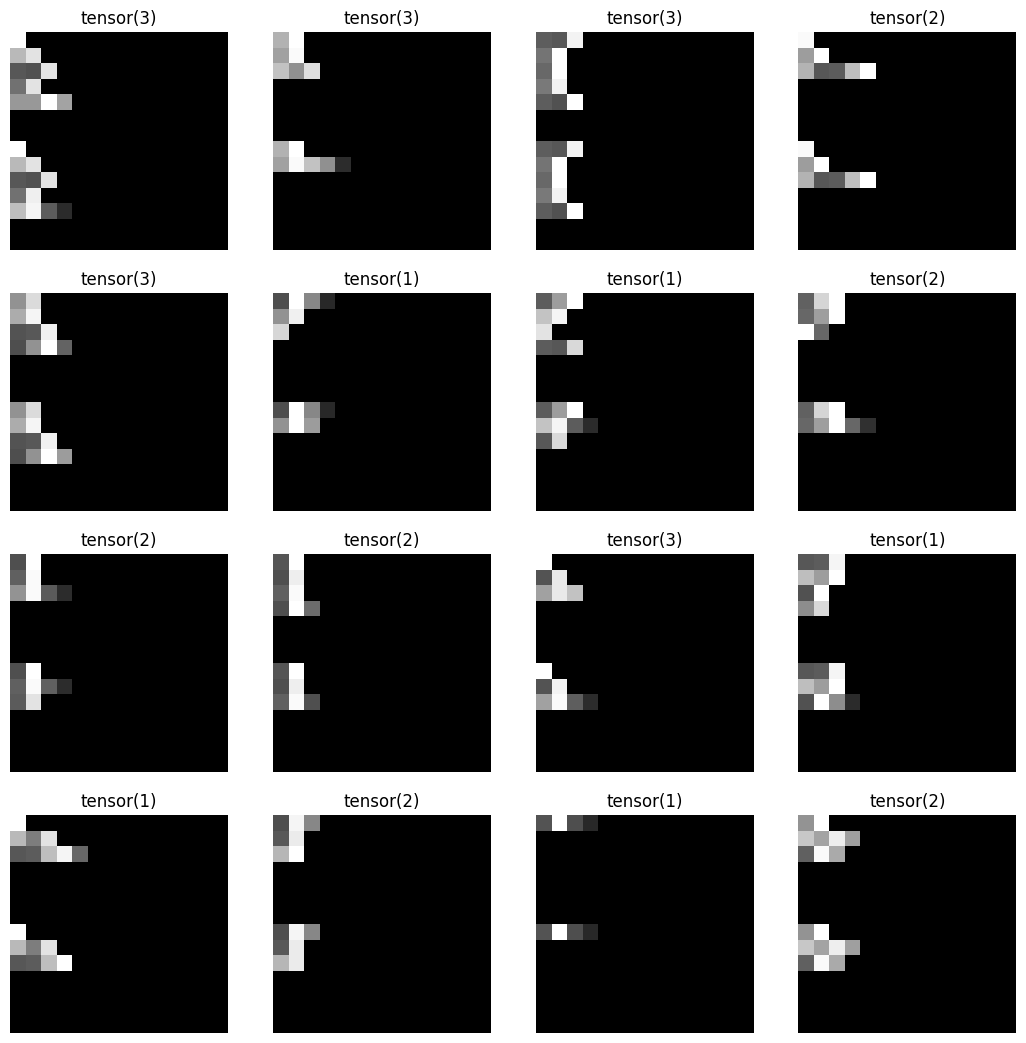

In [35]:
figure = plt.figure(figsize=(13, 13))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [36]:
num_epochs = 10
num_classes = 6
learning_rate = 0.001

In [37]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU() ,
            nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(4 * 4 * 64, 1000)
        self.fc2 = nn.Linear(1000, 7)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [38]:
model = ConvNet()

In [39]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=7, bias=True)
)

In [40]:
from torchsummary import summary

In [41]:
summary(model, (1, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
         AvgPool2d-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 7, 7]           8,256
              ReLU-5             [-1, 64, 7, 7]               0
         AvgPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                 [-1, 1000]       1,025,000
            Linear-9                    [-1, 7]           7,007
Total params: 1,040,583
Trainable params: 1,040,583
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 3.97
Estimated Total Size (MB): 4.18
---------------------------------------

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
#Train
model.to(device)

total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
       
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [100/1983], Loss: 1.1017, Accuracy: 46.88%
Epoch [1/10], Step [200/1983], Loss: 1.1577, Accuracy: 50.00%
Epoch [1/10], Step [300/1983], Loss: 0.9374, Accuracy: 53.12%
Epoch [1/10], Step [400/1983], Loss: 0.9290, Accuracy: 43.75%
Epoch [1/10], Step [500/1983], Loss: 0.9496, Accuracy: 56.25%
Epoch [1/10], Step [600/1983], Loss: 0.8580, Accuracy: 65.62%
Epoch [1/10], Step [700/1983], Loss: 1.0988, Accuracy: 56.25%
Epoch [1/10], Step [800/1983], Loss: 1.0779, Accuracy: 46.88%
Epoch [1/10], Step [900/1983], Loss: 0.9139, Accuracy: 62.50%
Epoch [1/10], Step [1000/1983], Loss: 0.9823, Accuracy: 50.00%
Epoch [1/10], Step [1100/1983], Loss: 0.8702, Accuracy: 53.12%
Epoch [1/10], Step [1200/1983], Loss: 0.8668, Accuracy: 68.75%
Epoch [1/10], Step [1300/1983], Loss: 0.9743, Accuracy: 59.38%
Epoch [1/10], Step [1400/1983], Loss: 0.7843, Accuracy: 59.38%
Epoch [1/10], Step [1500/1983], Loss: 0.8968, Accuracy: 56.25%
Epoch [1/10], Step [1600/1983], Loss: 1.1431, Accuracy: 50.00%
E

KeyboardInterrupt: ignored

In [ ]:
#Test
predictions_list = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted.cpu().numpy():
            predictions_list.append(i)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))


Test Accuracy of the model on test images: 65.97463284379172 %


In [ ]:
len(predictions_list)

29960

In [ ]:
df_result = pd.read_csv('/content/drive/MyDrive/zadanie/silero-stress-predictor/sample_submission.csv', index_col=[0])

In [ ]:
df_result['stress'] = predictions_list

In [ ]:
df_result

,stress
id,
0,3
1,3
2,3
3,2
4,1
...,...
29955,2
29956,2
29957,2


In [ ]:
df_result.to_csv('/content/drive/MyDrive/zadanie/silero-stress-predictor/result26.csv')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/zadanie/silero-stress-predictor/model_26_weights.pt')

In [ ]:
loaded_model = ConvNet()

In [ ]:
loaded_model.load_state_dict(torch.load('drive/MyDrive/zadanie/silero-stress-predictor/model_7_weights.pt'))

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=learning_rate)

In [ ]:
# Test the model
predictions_list = []
loaded_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  #for images, labels in test_loader:

        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted.cpu().numpy():
            predictions_list.append(i)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on test images: 70.18357810413886 %
